# Chapter 8 Modeling and Prediction for Processes on Network Graphs

* 데이터시각화 기초
* Statistical Analysis of Network Data with R [1]
* 김무성

# 차례

* 8.1 Introduction
* 8.2 Nearest Neighbor Methods
* 8.3 Markov Random Fields
* 8.4 Kernel Methods
* 8.5 Modeling and Prediction for Dynamic Processes

# 8.1 Introduction 

* Association
    - Often, however, it is some quantity (or attribute) associated with each of the elements that ultimately is of most interest. 
    - In such settings it frequently is not unreasonable to expect that this quantity be influenced in an important manner by the interactions among the elements.
    - For example
        - the behaviors and beliefs of people can be strongly influenced by their social interactions
        - proteins that are more similar to each other, with respect to their DNA sequence information, often are responsible for the same or related functional roles in a cell
        - computers more easily accessible to a computer infected with a virus may in turn themselves become more quickly infected
        - and the relative concentration of species in an environment (e.g., animal species in a forest or chemical species in a vat) can vary over time as a result of the nature of the relationships among species.
* Stocastic Processes on network graphs
    - Quantities associated with such phenomena can usefully be thought of as stochas-
tic processes defined on network graphs.
    - static process : { X_i }
    - dynamic process : { X_i(t) }

<img src='figures/eqGSP.png' />

# 8.2 Nearest Neighbor Methods

#### 참고자료

* Nearest Neighbor Methods ?

<img src="http://cgm.cs.mcgill.ca/~soss/cs644/projects/perrier/Image25.gif" />

<img src="http://www.biomedcentral.com/content/figures/1471-2164-9-531-1-l.jpg" width=600 />

* We begin by focusing on the problem of predicting a static process on a graph and
demonstrate the feasibility of doing so by examining one of the simplest of methods
for this task—nearest-neighbor prediction
* The average of the values of the vertex attribute vector X in the neighborhood N_i of i

<img src='figures/eq8.1.png' /> 

### We illustrate through the problem of protein function prediction.

* We illustrate through the problem of protein function prediction. 
* Recall, from our discussion of validation of graph partitioning in Chap. 4.4.3 and of assorta-
tivity and mixing in Chap. 4.5, that the affinity of proteins to physically bind to each other is known to be directly related to their participation in common cellular functions. 
* And, in fact, we found in our analysis of the data set yeast that the external assignment of proteins to functional classes correlated to a reasonable extent with their assignment to ‘communities’ by our graph partitioning algorithms.
* Furthermore, we saw examples of strong assortative mixing of protein function in the underlying network of protein–protein interactions. 
* While the gold standard for establishing the functionality of proteins is through direct experimental validation(or ‘assays’), results like these have been taken to suggest that, given the vast number of proteins yet to be annotated, it is natural to approach this problem from the perspective of statistical prediction. 
* Approaches to protein function prediction that incorporate network-based information have become standard.

#### Saccha-romyces cerevisiae

<img src='http://imgc.allpostersimages.com/images/P-473-488-90/64/6477/VCF6100Z/posters/simko-baker-s-or-brewer-s-yeast-saccharomyces-cerevisiae-with-some-budding-sem.jpg' />

* These data pertain to Baker’s yeast—the organism formally known as Saccha-romyces cerevisiae. 
* They were assembled by Jiang et al. [83], from various sources, and pertain to only those proteins annotated, as of January 2007, with the term cell communication in the gene ontology1 (GO) database—a standard database for terms describing protein function. 
* The vertex attribute ICSC is a binary vector

In [11]:
set.seed(42)
library(sand)

In [12]:
data(ppi.CC)

In [13]:
summary(ppi.CC)

IGRAPH UN-- 134 241 -- 
attr: name (v/c), ICSC (v/n), IPR000198 (v/n), IPR000403 (v/n),
  IPR001806 (v/n), IPR001849 (v/n), IPR002041 (v/n), IPR003527 (v/n)


In [14]:
# indicating those proteins annotated with the GO term intracellular signaling cascade (ICSC), 
# a specific form of cellular communication.
V(ppi.CC)$ICSC[1:10]

 [1] 1 1 1 1 1 0 1 1 1 1

In [15]:
V(ppi.CC)[ICSC == 1]$color <- "yellow"
V(ppi.CC)[ICSC == 0]$color <- "blue"

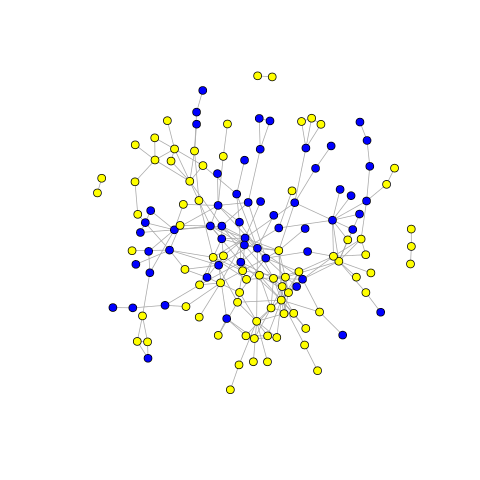

In [9]:
plot(ppi.CC, vertex.size=5, vertex.label=NA)
# We can see that there is a good deal of homogeneity to the vertex labels, 
# with neighbors frequently sharing the same color. 
# This observation suggests that local prediction of ICSC 
# on this network graph should be feasible.

#### guilt-by-association method

* In the context of protein function prediction, X is a binary vector, with entries indicating whether or not each protein is or is not annotated with a function of interest (e.g., ICSC). 
* In predicting binary vertex attributes, the nearest-neighbor averages (8.1) typically are compared to some threshold. 
*  For example, a threshold of 0.5 is commonly used, with a nearest-neighbor average greater than this value meaning that a majority of neighbors have the characteristic indicated by X = 1,resulting in a prediction for Xi of 1 as well. 

In [16]:
# A simple, but often quite effective, 
# method for producing local predictions is the nearest-neighbor method.

# In order to obtain some sense as to how effective the nearest-neighbor method
# might be in predicting ICSC in our yeast data set, 
# utilizing the information available through protein–protein interactions, 
# we can calculate the nearest-neighbor average 
# for each of the proteins in the giant connected component of our network.

clu <- clusters(ppi.CC)

In [17]:
ppi.CC.gc <- induced.subgraph(ppi.CC, clu$membership==which.max(clu$csize))

In [18]:
nn.ave <- sapply(V(ppi.CC.gc), function(x) mean(V(ppi.CC.gc)[nei(x)]$ICSC))

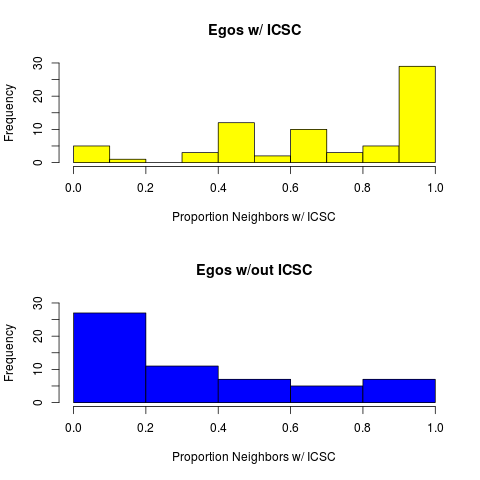

In [13]:
par(mfrow=c(2,1))
hist(nn.ave[V(ppi.CC.gc)$ICSC == 1], col="yellow", 
     ylim=c(0, 30), xlab="Proportion Neighbors w/ ICSC",
     main="Egos w/ ICSC")
hist(nn.ave[V(ppi.CC.gc)$ICSC == 0], col="blue",
     ylim=c(0, 30), xlab="Proportion Neighbors w/ ICSC",
     main="Egos w/out ICSC")
# The results, shown in Fig. 8.2, confirm that ICSC can be predicted 
# with fairly # good accuracy.

In [15]:
# In particular, using a threshold of 0.5 would yield an error rate of roughly 25 %.
nn.pred <- as.numeric(nn.ave > 0.5)
mean(as.numeric(nn.pred != V(ppi.CC.gc)$ICSC))

[1] 0.2598425

* Interestingly, we can push this illustration a bit further by taking advantage of the
evolving nature of biological databases like GO. 
* In particular, the proteins annotated in GO as not having a given biological function include both (1) those that indeed are known not to have that function, and (2) those whose status is simply unknown. 
* As a result, by comparing against more recent versions of GO, it is sometimes possible
to identify proteins whose status has changed for a given functional annotation, indicating that in the interim it has been discovered to in fact have that function.

In [30]:
# source("http://bioconductor.org/biocLite.R")
# biocLite("GOstats", suppressAutoUpdate=TRUE, suppressUpdates=TRUE)
library(GOstats)
library(GO.db)

In [31]:
# And the annotations specific to the organism yeast can be obtained 
#from the org.Sc.sgd.db database

# biocLite("org.Sc.sgd.db", suppressAutoUpdate=TRUE, suppressUpdates=TRUE)
library(org.Sc.sgd.db)

In [ ]:
# At the time of this writing, these annotations were last updated in September of
# 2013, roughly six years after the data in ppi.CC were assembled.


# We extract those proteins with the function ICSC—now subsumed3 under the
# term intercellular signaling transduction (ICST), or GO label 003556—and keep
# only those that have been identified from direct experimental assay, as indicated by
# the evidence code ‘IDA’.

x <- as.list(org.Sc.sgdGO2ALLORFS)
current.icst <- x[names(x) == "GO:0035556"]
ev.code <- names(current.icst[[1]])
icst.ida <- current.icst[[1]][ev.code == "IDA"]

In [38]:
# We then separate out the names of those proteins that had ICSC in our original data
orig.icsc <- V(ppi.CC.gc)[ICSC == 1]$name

In [ ]:
# and similarly extract the names of those proteins under the new annotations that
# were present in the giant connected component of our original network.

candidates <- intersect(icst.ida, V(ppi.CC.gc)$name)

In [ ]:
# Among these candidates, there are seven that have been newly discovered to have
# ICSC, with the following names.
new.icsc <- setdiff(candidates, orig.icsc)

In [19]:
# save(new.icsc, file='new.icsc.RData')
load('new.icsc.RData')

In [20]:
new.icsc

[1] "YDL159W" "YDL235C" "YHL007C" "YIL033C" "YIL147C" "YLR006C" "YLR362W"

In [21]:
# And among these seven, we find that three of them would have been correctly predicted
# by comparing the value of their nearest-neighbor averages to a threshold of 0.5.

nn.ave[V(ppi.CC.gc)$name %in% new.icsc]

[1] 0.7500000 0.4166667 0.3333333 0.6666667 0.8750000 0.0000000 0.0000000

# 8.3 Markov Random Fields

* 8.3.1 General Characterization
* 8.3.2 Auto-Logistic Models
* 8.3.3 Inference and Prediction for Auto-logistic Models
* 8.3.4 Goodness of Fit

## 8.3.1 General Characterization

#### 참고자료

* MRF ? - http://en.wikipedia.org/wiki/Markov_random_field

<img src='http://upload.wikimedia.org/wikipedia/en/f/f7/Markov_random_field_example.png' />

<img src="http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0809/ORCHARD/blanket.jpg" />

<img src="http://nghiaho.com/wp-content/uploads/2012/06/MRF.png" /> 

<img src="https://sites.google.com/site/diangong/MRF2.JPG" />

<img src="http://yosinski.com/mlss12/media/slides/MLSS-2012-Wainwright-Graphical-Models-and-Message-Passing_085.png" />

* The concept of an MRF can be seen as a generalization of a Markov chain (common in the modeling of temporal data) and has its roots in statistical mechanics, going back to the work of Ising [80] on ferromagnetic fields. MRFs are used extensively in spatial statistics (e.g., see Cressie [37, Chap. 6.4]) and in image analysis (e.g., see Li [100]).

<img src='figures/defmrf.png' /> 

<img src='figures/eq8.4.png' /> 

<img src='figures/eq8.5.png' /> 

<img src='figures/eq8.6.png' /> 

##8.3.2 Auto-Logistic Models

* Auto-Logistic Models - https://tgmstat.wordpress.com/2013/01/18/auto-logistic-model/

* In practice, these models often are simplified by assumptions of homogeneity, in the sense that the form of the clique potentials U_c is assumed not to depend on the particular positions of the cliques c ∈ C . Furthermore, usually cliques of only a limited size are defined to have non-zero partition functions U_c , which reduces the complexity of the decomposition in (8.6). This later step has direct implications on the nature of the assumed dependency in X.

* Here we will focus on a class of MRFs commonly used in network analysis for modeling binary vertex attribute data, like the indicators of protein function (e.g.,ICSC) discussed previously. These models are sometimes referred to as auto-logistic models.

* The class of auto-logistic models goes back to Besag [12], who suggested introducing the additional conditions on MRFs that 
    - (i) ‘pairwise-only dependence.’
        -  only cliques c ∈ C of size one or two have non-zero potential functions U_c  = 
    - (ii) 'exponential family form' 
        - the conditional probabilities in (8.3) have an exponential family form (i.e., a form like that in (6.1)).  

### enery function

#### auto-models

<img src='figures/eq8.7.png' /> 

* Now suppose that the Xi are binary random variables (i.e., taking on just the values zero and one). Under appropriate normalization conditions, the functions H_i can be made to only contribute to the expansion of U(x) in (8.6) in a non-trivial fashion when x_i = 1, in which case (8.7) can be shown to be equivalent in form to


<img src='figures/eq8.8.png' /> 

#### auto-logistic models

<img src='figures/eq8.9.png' /> 

##### Assumption of homogeneity

<img src='figures/eq8.10.png' /> 

<img src='figures/eq8.11.png' /> 

* Hence, we see that such (homogeneous) auto-logistic models effectively can be viewed as probabilistic extensions of nearest-neighbor methods.

<img src='figures/eq8.12.png' /> 

#### The specification of such models thus requires three pieces:

* the network process X to be modeled, 
* the network G, 
* and the set of relevant exogenous variables (if any). 

In [24]:
# install.packages("ngspatial")
library(ngspatial)

In [25]:
X <- V(ppi.CC.gc)$ICSC
A <- get.adjacency(ppi.CC.gc, sparse=FALSE)

In [20]:
# The last specification depends on what additional information we wish to incorporate. 
# For example, if, as in (8.11), we wish only to have an intercept, then we indicate this by

formula1 <- X ~ 1

#### 참고자료

* motif ? - http://ghr.nlm.nih.gov/glossary=motif

<img src="http://www.nature.com/nbt/journal/v24/n4/images/nbt0406-423-F1.gif" />

In [27]:
# Alternatively, biology tells us that various types of protein-specific information
# besides interactions can be useful in predicting protein function. 
# An example is information on the genetic sequence underlying that gene coding for a given protein.
# For instance, genetic motifs are short sequences of DNA thought to have biological significance, 
# such as by influencing the spatial configuration of proteins. 
# Indicators of the presence or absence of six such motifs are included with the network ppi.CC as vertex attribute variables, 
# each starting with the letters ‘IPR’. These are natural candidates for exogenous variables in our model.
    
gene.motifs <- cbind(V(ppi.CC.gc)$IPR000198,
                               V(ppi.CC.gc)$IPR000403,
                               V(ppi.CC.gc)$IPR001806,
                               V(ppi.CC.gc)$IPR001849,
                               V(ppi.CC.gc)$IPR002041,
                               V(ppi.CC.gc)$IPR003527)

formula2 <- X ~ gene.motifs

## 8.3.3 Inference and Prediction for Auto-logistic Models

* As with our treatment of the nearest-neighbor method, we focus again on the task of prediction of network processes X. However, unlike previously, we require
    - knowledge of the handful of parameters in our models in order to generate predictions.
    - In the specific context of the auto-logistic models (8.12), we require
        - α 
        - β
* Given measurements of X, we can try to infer these parameters from the data.

<img src='figures/eq8.13.png' /> 

* Unfortunately, calculation of κ (α , β ) is prohibitive !!


#### pseudo log-likelihood

<img src='figures/eq8.14.png' /> 

#### MPLE (Maximum Pseudo-Likelihood Estimate)

<img src='figures/eq8.15.png' /> 

In [25]:
m1.mrf <- autologistic(formula1, A=A, control=list(confint="none"))

In [26]:
m1.mrf$coefficients
# we see, for example, that in these data the addition of one neighboring protein with
# the function ICSC is estimated to increase the log-odds of the ego protein having
# ICSC by a factor of roughly 1.135.

(Intercept)         eta 
  0.2004949   1.1351942 

In [27]:
mrf1.pred <- as.numeric((m1.mrf$fitted.values > 0.5))

In [28]:
mean(as.numeric(mrf1.pred != V(ppi.CC.gc)$ICSC))
# yields an error rate of roughly 20 %.

[1] 0.2047244

In [43]:
# This may be compared to the 25 % error rate we witnessed with the nearest-neighbor method. 
# However, with respect to the four proteins that were discovered to have ICSC between 2007 and 2013, 
# we find that this model and the nearest-neighbor method make similar predictions.

m1.mrf$fitted.values[V(ppi.CC.gc)$name %in% new.icsc]

[1] 0.7519142 0.1658647 0.2184092 0.6451897 0.9590030 0.2595863 0.3956048

In [44]:
# The inclusion of gene motif information in our model
m2.mrf <- autologistic(formula2, A=A, control=list(confint="none"))

In [45]:
m2.mrf$coefficients

  (Intercept)  gene.motifs1  gene.motifs2  gene.motifs3  gene.motifs4 
 5.081573e-02  1.876848e+00  1.875217e+01  1.875217e+01  1.824990e+01 
 gene.motifs5  gene.motifs6           eta 
 8.487244e-08 -1.837997e+01  1.297921e+00 

In [46]:
mrf.pred2 <- as.numeric((m2.mrf$fitted.values > 0.5))
mean(as.numeric(mrf.pred2 != V(ppi.CC.gc)$ICSC))
# And the error rate improves slightly.

[1] 0.1889764

In [47]:
m2.mrf$fitted.values[V(ppi.CC.gc)$name %in% new.icsc]

[1] 0.7829254 0.4715219 0.4962188 0.6570828 0.7829254 0.2175373 0.3510037

##8.3.4 Goodness of Fit

In [ ]:
# The following code simulates 100 realizations from each of the two auto-logistic models 
# considered above for the prediction of the protein function ICSC. 

# The function rautologistic in the ngspatial package 
# can be used to simulate realizations of centered autologistic models.

In [48]:
srand(42) # random seed for rautologistic

In [49]:
ntrials <- 100

In [50]:
a1.mrf <- numeric(ntrials)

In [51]:
a2.mrf <- numeric(ntrials)

In [52]:
Z1 <- rep(1,length(X))

In [53]:
Z2 <- cbind(Z1, gene.motifs)

In [54]:
for(i in 1:ntrials)
{
  X1.mrf <- rautologistic(as.matrix(Z1), A=A, theta=m1.mrf$coefficients)
  X2.mrf<- rautologistic(as.matrix(Z2), A=A, theta=m2.mrf$coefficients)
  a1.mrf[i] <- assortativity(ppi.CC.gc, X1.mrf+1, directed=FALSE)
  a2.mrf[i] <- assortativity(ppi.CC.gc, X2.mrf+1, directed=FALSE)
}

In [30]:
assortativity(ppi.CC.gc, X+1, directed=FALSE)
# The assortativity coefficient for the originally observed labels of ICSC function is
# roughly 0.37—fairly high, consistent with our findings that ICSC may be predicted
# reasonably well from protein–protein interactions.

[1] 0.3739348

In [ ]:
# Comparing this value to the distribution of those values obtained under our two
# models, we find that it falls in the upper quartile.

In [56]:
summary(a1.mrf)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05588 0.21330 0.27330 0.27290 0.33680 0.54200 

In [57]:
summary(a2.mrf)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.008646  0.217600  0.273400  0.266400  0.321900  0.435400 

* This suggests that the goodness-of-fit of our models, while not bad, can likely still be improved upon.


# 8.4 Kernel Methods

* 8.4.1 Designing Kernels on Graphs
* 8.4.2 Kernel Regression on Graphs

## 8.4.1 Designing Kernels on Graphs

#### 참고자료 

* graph laplacian - http://www.lix.polytechnique.fr/~schwander/resources/mig/slides/pati.pdf

<img src="http://www.cs.berkeley.edu/~demmel/cs267/lecture20/LaplacianMatrix.gif" />

* kernel method ? kernel matrix ?

<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Svm_8_polinomial.JPG/300px-Svm_8_polinomial.JPG" />

<img src="https://www.dtreg.com/uploaded/pageimg/SvmDimensionMap.jpg" />

<img src="http://www.wikicoursenote.com/w/images/thumb/b/bc/Fig1.jpg/400px-Fig1.jpg" />

<img src="https://developer.apple.com/library/ios/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg" />

* eigenvalue, eigenvector ?

<img src="http://tutorial.math.lamar.edu/Classes/DE/LA_Eigen_files/eq0073MP.gif" />

<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Eigenvalue_equation.svg/250px-Eigenvalue_equation.svg.png" />

<img src="http://www.chemie.uni-hamburg.de/nmr/insensitive/tutorial/formula_diagonal_matrix.png" />

<img src="https://onlinecourses.science.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/lesson05/PCA_plot.gif" />

<img src="http://www.kgs.ku.edu/Hexacoral/Products/Report/HTML_Report/WLV/Web-LoiczView%20Help%20Principal%20Components%20Analysis_files/eigenvaluePlot.gif" />

* positive semi-definite ?

<img src="http://cfile29.uf.tistory.com/image/2160C03752660CD3044B0F" />

<img src="http://www.matlabinuse.com/files/attach/images/2429/056/021/87fbfeeab7db157b9d8f0835bc18177b.png" />

* (pseudo) inverse matrix ?

<img src="http://www.matlabinuse.com/files/attach/images/2429/101/011/dd03b4960bb959c15d0b0e6fc7456ff9.png" />

<img src="http://www.matlabinuse.com/files/attach/images/2429/101/011/a63a5f2a4d3e130fe5aa28720cdf7963.png" />

* orthogonal matrix ?

<img src="http://www.euclideanspace.com/maths/algebra/matrix/orthogonal/basis.gif" />

* diagonal matrix ?

<img src="http://people.revoledu.com/kardi/tutorial/LinearAlgebra/images/MatrixDiagonal_clip_image003.gif" />

<img src='figures/eq8.16-0.png' /> 

<img src='figures/eq8.16.png' /> 

<img src='figures/eq8.17.png' /> 

<img src='figures/eq8.18.png' /> 

<img src='figures/eq8.19.png' /> 

In [58]:
L <- as.matrix(graph.laplacian(ppi.CC.gc))

In [59]:
e.L <- eigen(L)

In [60]:
nv <- vcount(ppi.CC.gc)

In [61]:
e.vals <- e.L$values[1:(nv-1)]

In [63]:
f.e.vals <- c((e.vals)^(-1), 0)

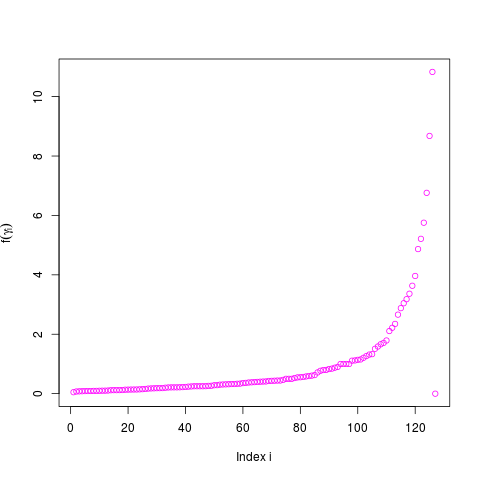

In [64]:
plot(f.e.vals, col="magenta", xlim=c(1, nv), xlab=c("Index i"), ylab=expression(f(gamma[i])))

In [65]:
e.vec <- e.L$vectors[, (nv-1)]

In [66]:
v.colors <- character(nv)

In [67]:
v.colors[e.vec >= 0] <- "red"

In [68]:
v.colors[e.vec < 0] <- "blue"

In [69]:
v.size <- 15 * sqrt(abs(e.vec))

In [70]:
l <- layout.fruchterman.reingold(ppi.CC.gc)

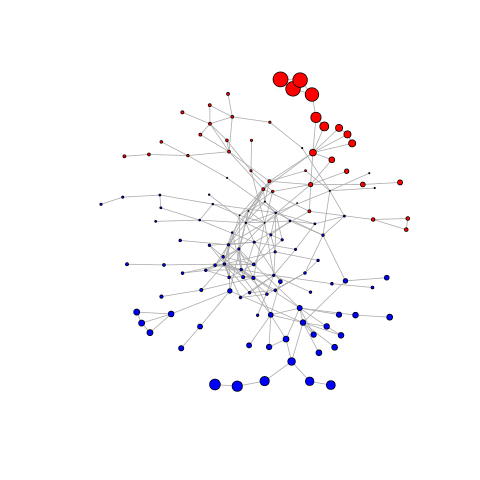

In [71]:
plot(ppi.CC.gc, layout=l, vertex.color=v.colors, vertex.size=v.size, vertex.label=NA)

In [72]:
library(kernlab)

In [73]:
K1.tmp <- e.L$vectors %*% diag(f.e.vals) %*% t(e.L$vectors)

In [74]:
K1 <- as.kernelMatrix(K1.tmp)

In [75]:
K.motifs <- gene.motifs %*% t(gene.motifs)

In [76]:
K2.tmp <- 0.5 * K1.tmp + 0.5 * K.motifs

In [77]:
K2 <- as.kernelMatrix(K2.tmp)

## 8.4.2 Kernel Regression on Graphs

#### 참고자료

* kernel regression ? 

<img src="http://people.revoledu.com/kardi/tutorial/Regression/KernelRegression/Image/Kernel_clip_image002_1.gif" />

<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/KernelTypes.png/220px-KernelTypes.png" />

<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Localregressionsmoother.svg/900px-Localregressionsmoother.svg.png" />

<img src="http://ieeexplore.ieee.org/ieee_pilot/articles/04/ttg2009040572/assets/img/article_1/fig_2/large.gif" />

* SVM ? 

<img src="http://i.stack.imgur.com/1gvce.png" />

<img src="http://docs.opencv.org/_images/optimal-hyperplane.png" />

<img src="http://www.ctocio.com/wp-content/uploads/2014/06/SVM-580x460.jpg" />

<img src="https://www.eleceng.adelaide.edu.au/personal/dabbott/wiki/images/2/2a/F_SVM.jpg" />

<img src='figures/eq8.20.png' /> 

<img src='figures/eq8.21.png' /> 

<img src='figures/eq8.22.png' /> 

In [78]:
m1.svm <- ksvm(K1, X, type="C-svc")
m1.svm.fitted <- fitted(m1.svm)

In [79]:
mean(as.numeric(m1.svm.fitted != V(ppi.CC.gc)$ICSC))

[1] 0.1102362

In [80]:
m1.svm.fitted[V(ppi.CC.gc)$name %in% new.icsc]

[1] 1 1 1 0 1 0 0

In [81]:
mean(as.numeric(m1.svm.fitted != V(ppi.CC.gc)$ICSC))

[1] 0.1102362

In [82]:
m1.svm.fitted[V(ppi.CC.gc)$name %in% new.icsc]

[1] 1 1 1 0 1 0 0

In [83]:
m2.svm <- ksvm(K2, X, type="C-svc")

In [84]:
m2.svm.fitted <- fitted(m2.svm)

In [85]:
mean(as.numeric(m2.svm.fitted != V(ppi.CC.gc)$ICSC))

[1] 0.06299213

In [86]:
m2.svm.fitted[V(ppi.CC.gc)$name %in% new.icsc]

[1] 1 0 0 0 1 0 0

# 8.5 Modeling and Prediction for Dynamic Processes

* 8.5.1 Epidemic Processes: An Illustration

<img src='figures/markov_processes.png' /> 

## 8.5.1 Epidemic Processes: An Illustration

### Traditional Epidemic Modeling

#### 참고 : SIR model ? 

* https://lsy5518.wordpress.com/2014/09/28/sir-%EB%AA%A8%EB%8D%B8-sir-model/

<img src="http://ct.kaist.ac.kr/ctpress/wp-content/uploads/2011/09/06.png" />

<img src='figures/eq8.23.png' /> 

<img src='figures/eq8.23-1.png' /> 

<img src='figures/fig8.5.png' /> 

### Network-Based Epidemic Modeling

<img src='figures/eq8.24.png' /> 

* 참고자료  - http://rsif.royalsocietypublishing.org/content/2/4/295

<img src="http://rsif.royalsocietypublishing.org/content/royinterface/2/4/295/F1.large.jpg" width=600/>

<img src="http://rsif.royalsocietypublishing.org/content/2/4/295/F2.large.jpg" width=600 />

<img src="http://rsif.royalsocietypublishing.org/content/2/4/295/F3.large.jpg" width=600 />

In [87]:
gl <- list()
gl$ba <- barabasi.game(250, m=5, directed=FALSE)
gl$er <- erdos.renyi.game(250, 1250, type=c("gnm"))
gl$ws <- watts.strogatz.game(1, 100, 12, 0.01)

In [88]:
beta <- 0.5
gamma <- 1
ntrials <- 100

In [89]:
sim <- lapply(gl, sir, beta=beta, gamma=gamma, no.sim=ntrials)

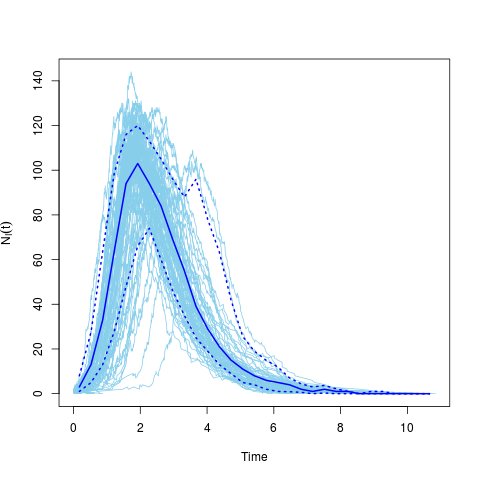

In [94]:
plot(sim$er)

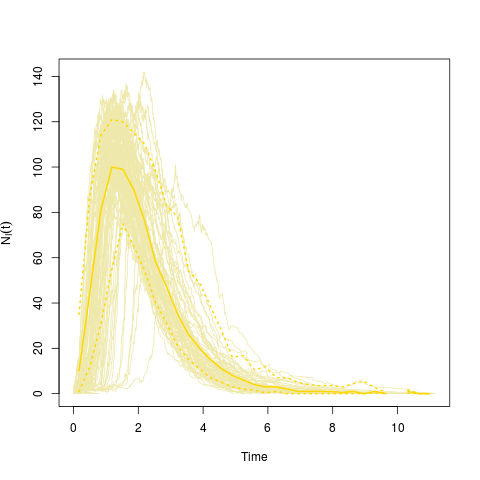

In [91]:
plot(sim$ba, color="palegoldenrod", median_color="gold", quantile_color="gold")

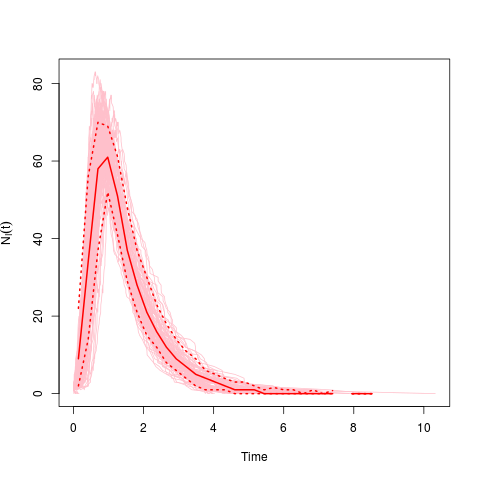

In [92]:
plot(sim$ws, color="pink", median_color="red", quantile_color="red")

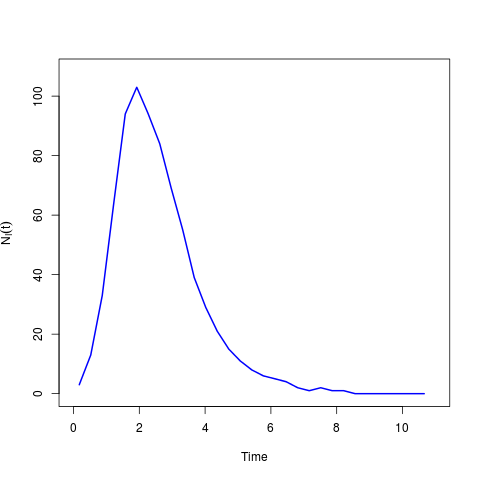

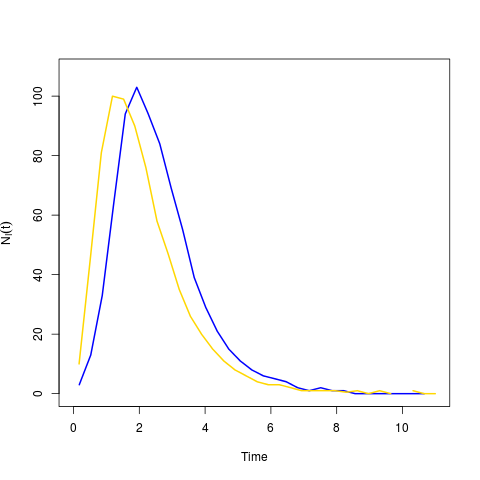

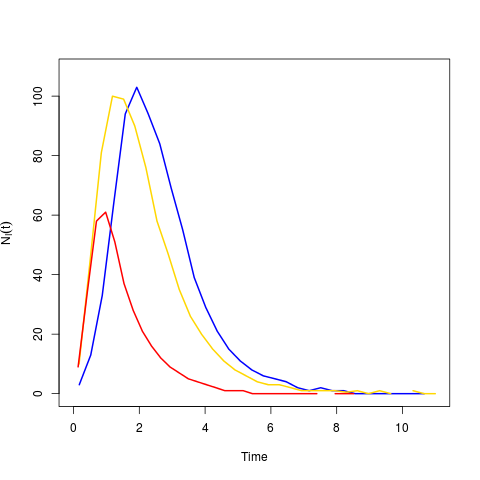

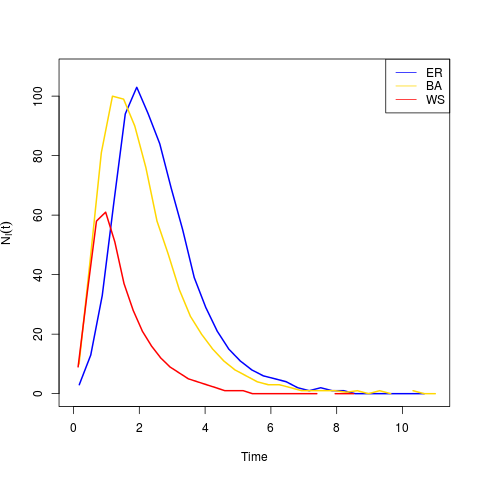

In [95]:
x.max <- max(sapply(sapply(sim, time_bins), max))
y.max <- 1.05 * max(sapply(sapply(sim, function(x) median(x)[["NI"]]), max, na.rm=TRUE))

plot(time_bins(sim$er), median(sim$er)[["NI"]], type="l", lwd=2, col="blue", xlim=c(0, x.max), ylim=c(0, y.max), xlab="Time", ylab=expression(N[I](t)))
lines(time_bins(sim$ba), median(sim$ba)[["NI"]], lwd=2, col="gold")
lines(time_bins(sim$ws), median(sim$ws)[["NI"]], lwd=2, col="red")
legend("topright", c("ER", "BA", "WS"), col=c("blue", "gold", "red"), lty=1)

# 참고자료 

* [1] Statistical Analysis of Network Data with R